## Downloading packages

In [ ]:
!pip install trimesh
!pip install --upgrade ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 711.2/711.2 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.8 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


## Mounting to Google Drive

In [ ]:
import os
from google.colab import drive

# Define the base path for your Google Drive.
base_path = '/content/drive'

# Define the specific folder path within your Google Drive.
folder_path = 'MyDrive/Colab Notebooks/Machine Learning and Deep Learning/Project'

# Combine the base path and folder path to create the full mount path.
full_project_path = os.path.join(base_path, folder_path)

# Mount your drive.
drive.mount(base_path, force_remount=True)

Mounted at /content/drive


## Creating custom dataset

In [ ]:
import os
import yaml
import numpy as np
import json
import torch
import trimesh
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image

class PoseEstimationDataset(Dataset):
    def __init__(self, dataset_root,
                 models_root,
                 folders=list(range(1, 16)),
                 split='train',
                 train_ratio=0.8,
                 seed=42,
                 img_size=(224, 224)):

        self.dataset_root = dataset_root
        self.models_root = models_root
        self.split = split
        self.train_ratio = train_ratio
        self.seed = seed
        self.img_size = img_size
        self.models = {}
        self.invalid_entries = 0

        self.models_info_path = os.path.join(models_root, 'models_info.yml')
        with open(self.models_info_path, 'r') as f:
            self.models_info = yaml.safe_load(f)

        # Cache gt.yml and info.yml per object
        self.gt_data = {}
        self.info_data = {}
        self.all_samples = []  # List of tuples: (object_id, sample_id)

        for obj_id in folders:
            obj_folder = os.path.join(dataset_root, f"{obj_id:02d}")
            gt_path = os.path.join(obj_folder, 'gt.yml')
            info_path = os.path.join(obj_folder, 'info.yml')

            if not os.path.exists(gt_path):
                continue

            with open(gt_path, 'r') as f:
                gt = yaml.safe_load(f)
            with open(info_path, 'r') as f:
                info = yaml.safe_load(f)

            self.gt_data[obj_id] = gt
            self.info_data[obj_id] = info

            for sample_id in gt.keys():
                self.all_samples.append((obj_id, int(sample_id)))

        # Get unique sorted object IDs
        object_id_set = set()
        for obj_id, sample_id in self.all_samples:
            annotations = self.gt_data[obj_id][sample_id]
            for ann in annotations:
                object_id_set.add(ann['obj_id'])
        self.object_ids = sorted(object_id_set)
        self.id_to_idx = {obj_id: i for i, obj_id in enumerate(self.object_ids)}
        self.idx_to_id = {i: obj_id for obj_id, i in self.id_to_idx.items()}

        if not self.all_samples:
            raise ValueError(f"No samples found in {dataset_root}. Check dataset structure.")

        # Split dataset
        train, test = train_test_split(self.all_samples, train_size=self.train_ratio, random_state=self.seed)
        self.samples = train if self.split == 'train' else test

        self.transform = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.samples)

    def save_mapping(self, filepath=None):
        if filepath is None:
            filepath = "object_id_mapping.json"
        with open(filepath, "w") as f:
            json.dump(self.id_to_idx, f)

    @staticmethod
    def load_mapping(filepath=None):
        if filepath is None:
            filepath = "object_id_mapping.json"
        with open(filepath, "r") as f:
            mapping = json.load(f)
        return {int(k): v for k, v in mapping.items()}

    def printIDMapping(self):
        print("Object ID Mapping (Original → Mapped):")
        for orig_id in self.object_ids:
            print(f"  {orig_id:02d} → {self.id_to_idx[orig_id]}")

    def nrInvalidObjects(self):
        return self.invalid_entries

    def getMappedIDs(self, ids=None): # If None it returns all.
        mapped_ids = []
        orig_ids = []
        if ids is None:
            for orig_id in self.object_ids:
                mapped_ids.append(self.id_to_idx[orig_id])
                orig_ids.append(orig_id)
        else:
            for id in ids:
                if id in self.id_to_idx:
                    mapped_ids.append(self.id_to_idx[id])
                    orig_ids.append(id)
                else:
                    print(f"⚠️ Warning: Object ID {id} not found in dataset and will be ignored.")
        return mapped_ids, orig_ids

    def get_model_info(self, object_id):
        if object_id not in self.models_info:
            raise ValueError(f"Object ID {object_id} not in models_info.yml")
        return self.models_info[object_id]

    def load_3D_model(self, object_id):
        if object_id in self.models:
            return self.models[object_id]

        model_path = os.path.join(self.models_root, f"obj_{object_id:02d}.ply")
        mesh = trimesh.load(model_path)
        points = mesh.vertices.astype(np.float32) / 1000.0  # Convert mm to meters
        self.models[object_id] = points
        return points

    def cropImages(self, image, annotations, cam_K, depth_image=None):
        crop_entries = []
        width, height = image.size

        for ann in annotations:
            x, y, w, h = ann['obj_bb']
            x1 = max(0, x)
            y1 = max(0, y)
            x2 = min(width, x + w)
            y2 = min(height, y + h)

            # Filtering out entries with invalid boundry boxes.
            if x2 <= x1 or y2 <= y1:
                self.invalid_entries += 1
                continue

            cropped = image.crop((x1, y1, x2, y2))
            original_crop_width, original_crop_height = cropped.size

            cropped_K = cam_K.clone()
            cropped_K[0, 2] -= x1
            cropped_K[1, 2] -= y1

            cropped = cropped.resize(self.img_size, Image.BILINEAR)
            scale_x = self.img_size[0] / original_crop_width
            scale_y = self.img_size[1] / original_crop_height
            cropped_K[0, 0] *= scale_x
            cropped_K[0, 2] *= scale_x
            cropped_K[1, 1] *= scale_y
            cropped_K[1, 2] *= scale_y

            cropped_rgb_tensor = self.transform(cropped)
            R_mat = np.array(ann['cam_R_m2c'], dtype=np.float32).reshape(3, 3)
            t_vec = np.array(ann['cam_t_m2c'], dtype=np.float32) / 1000.0

            # depth.
            if depth_image is not None:
                cropped_depth = depth_image.crop((x1, y1, x2, y2))
                cropped_depth = cropped_depth.resize(self.img_size, Image.BILINEAR)
                cropped_depth_tensor = transforms.ToTensor()(cropped_depth)  # (1, H, W)
            else:
                cropped_depth_tensor = None

            norm_bbox = torch.tensor([
                x1 / width,
                y1 / height,
                (x2 - x1) / width,
                (y2 - y1) / height
            ], dtype=torch.float32)

            crop_entries.append({
                'cropped_rgb': cropped_rgb_tensor,
                'cropped_depth': cropped_depth_tensor,
                'cropped_K': cropped_K,
                'object_id': ann['obj_id'],
                'bbox': ann['obj_bb'],
                'norm_bbox': norm_bbox,
                'rotation': R_mat,
                'translation': t_vec
            })

        return crop_entries, cam_K

    def __getitem__(self, idx):
        object_id, sample_id = self.samples[idx]
        folder = os.path.join(self.dataset_root, f"{object_id:02d}")

        rgb_path = os.path.join(folder, 'rgb', f"{sample_id:04d}.png")
        if not os.path.exists(rgb_path):
            raise FileNotFoundError(f"RGB image not found: {rgb_path}")
        rgb = Image.open(rgb_path).convert("RGB")

        depth_path = os.path.join(folder, 'depth', f"{sample_id:04d}.png")
        if not os.path.exists(depth_path):
            raise FileNotFoundError(f"Depth image not found: {depth_path}")
        depth = Image.open(depth_path)
        depth_np = np.array(depth).astype(np.float32)  # e.g., depth in mm
        depth_np = np.clip(depth_np, 0, 2000) / 2000.0  # normalize to [0, 1]
        depth_img = Image.fromarray((depth_np * 255).astype(np.uint8))

        annotations = self.gt_data[object_id][sample_id]
        cam_K = torch.tensor(np.array(self.info_data[object_id][sample_id]['cam_K']).reshape(3, 3), dtype=torch.float32)

        crop_entries, org_K = self.cropImages(rgb, annotations, cam_K, depth_image=depth_img)

        # ✅ Fix: remap each entry's object_id correctly
        for entry in crop_entries:
            true_obj_id = entry['object_id']
            if true_obj_id not in self.id_to_idx:
                raise ValueError(f"Object ID {true_obj_id} not found in id_to_idx mapping.")
            entry['object_id'] = self.id_to_idx[true_obj_id]  # use actual mapping

        return {
            'sample_id': sample_id,
            'original_rgb': rgb,
            'original_K': org_K,
            'objects': crop_entries
        }

## PoseNet6D using RGB-D data

In [ ]:
import torch.nn.functional as F
from torchvision.models import resnet18, ResNet18_Weights
from torch import nn


class PoseNet_RGBD(nn.Module):
    def __init__(self, num_objects,
                 embedding_dim=16,
                 img_size=(224, 224),
                 weights=ResNet18_Weights.DEFAULT):

        super().__init__()
        self.img_size = img_size

        # === RGB Encoder (ResNet18) ===
        rgb_backbone = resnet18(weights=weights)
        self.rgb_encoder = nn.Sequential(*list(rgb_backbone.children())[:-2])
        self.global_pool_rgb = nn.AdaptiveAvgPool2d(1)

        # === Depth Encoder (Custom small CNN) ===
        self.depth_encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # -> 112x112
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # -> 56x56
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )

        self.obj_embedding = nn.Embedding(num_embeddings=num_objects,
                                          embedding_dim=embedding_dim)

        fused_dim = 512 + 128 + 4 + embedding_dim  # RGB + depth + bbox + obj_id

        self.fc_depth = nn.Sequential(
            nn.Linear(fused_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

        self.fc_rotation = nn.Sequential(
            nn.Linear(fused_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 4)
        )

    def forward(self, x_rgb, x_depth, norm_bbox, K_crop, object_id):
        B = x_rgb.shape[0]

        # === RGB Feature Extraction ===
        rgb_feat = self.rgb_encoder(x_rgb)             # (B, 512, 7, 7)
        rgb_feat = self.global_pool_rgb(rgb_feat).view(B, -1)  # (B, 512)

        # === Depth Feature Extraction ===
        depth_feat = self.depth_encoder(x_depth)       # (B, 128)

        # === Object Embedding ===
        object_id = object_id.to(self.obj_embedding.weight.device)
        obj_feat = self.obj_embedding(object_id)       # (B, embedding_dim)

        # === Fusion ===
        x = torch.cat([rgb_feat, depth_feat, norm_bbox, obj_feat], dim=1)  # (B, fused_dim)

        # === Depth (Z) Prediction ===
        depth = self.fc_depth(x).squeeze(1)
        depth = torch.clamp(depth, min=0.1, max=1.5)

        # === Quaternion Prediction ===
        quat = F.normalize(self.fc_rotation(x), dim=1)

        # === 2D → 3D projection to get translation ===
        fx = K_crop[:, 0, 0]
        fy = K_crop[:, 1, 1]
        cx_crop = K_crop[:, 0, 2]
        cy_crop = K_crop[:, 1, 2]

        img_w, img_h = self.img_size
        u = (norm_bbox[:, 0] + 0.5 * norm_bbox[:, 2]) * img_w
        v = (norm_bbox[:, 1] + 0.5 * norm_bbox[:, 3]) * img_h

        x_cam = (u - cx_crop) * depth / fx
        y_cam = (v - cy_crop) * depth / fy
        z_cam = depth

        translation = torch.stack([x_cam, y_cam, z_cam], dim=1)
        return translation, quat

## Helper functions

In [ ]:
import torch.nn.functional as F
from scipy.spatial.transform import Rotation as R
from scipy.spatial import cKDTree

def computeADD(R_pred, t_pred, R_gt, t_gt, model_points):
    # Converting all inputs into NumPy.
    def to_np(x):
        return x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else x
    R_pred, t_pred = to_np(R_pred), to_np(t_pred)
    R_gt, t_gt = to_np(R_gt), to_np(t_gt)
    model_points = to_np(model_points)

    # Transforming model points.
    pred_pts = model_points @ R_pred.T + t_pred
    gt_pts = model_points @ R_gt.T + t_gt

    # Returning ADD for the prediction.
    distances = np.linalg.norm(pred_pts - gt_pts, axis=1)
    return distances.mean()

def matrix_to_quaternion_batch(rotation_matrix):
    if rotation_matrix.dim() == 2:  # If it's a single 3x3 matrix
        rotation_matrix = rotation_matrix.unsqueeze(0)  # Add a batch dimension

    batch_size = rotation_matrix.size(0)
    quaternions = torch.zeros(batch_size, 4, device=rotation_matrix.device)

    # Compute trace and clamp for numerical safety
    trace = torch.diagonal(rotation_matrix, dim1=1, dim2=2).sum(dim=1)
    trace = torch.clamp(trace, min=-0.999)  # Prevent sqrt of negative

    s = torch.sqrt(1.0 + trace) / 2.0  # Safe sqrt
    quaternions[:, 0] = s

    # Prevent division by zero
    denom = 4.0 * s
    denom = torch.clamp(denom, min=1e-6)

    quaternions[:, 1] = (rotation_matrix[:, 2, 1] - rotation_matrix[:, 1, 2]) / denom
    quaternions[:, 2] = (rotation_matrix[:, 0, 2] - rotation_matrix[:, 2, 0]) / denom
    quaternions[:, 3] = (rotation_matrix[:, 1, 0] - rotation_matrix[:, 0, 1]) / denom

    # Normalize to ensure unit quaternion
    quaternions = F.normalize(quaternions, dim=1)

    return quaternions

def quaternion_to_matrix_batch(quat):
    # Adding the batch dimension if single quaternion.
    if quat.dim() == 1:
        quat = quat.unsqueeze(0)

    # Extracting the elements.
    w, x, y, z = quat[:, 0], quat[:, 1], quat[:, 2], quat[:, 3]

    B = quat.size(0) # Re-shaping.
    R = torch.zeros((B, 3, 3), device=quat.device)

    # Calculating elementswise.
    R[:, 0, 0] = 1 - 2 * (y**2 + z**2)
    R[:, 0, 1] = 2 * (x * y - z * w)
    R[:, 0, 2] = 2 * (x * z + y * w)
    R[:, 1, 0] = 2 * (x * y + z * w)
    R[:, 1, 1] = 1 - 2 * (x**2 + z**2)
    R[:, 1, 2] = 2 * (y * z - x * w)
    R[:, 2, 0] = 2 * (x * z - y * w)
    R[:, 2, 1] = 2 * (y * z + x * w)
    R[:, 2, 2] = 1 - 2 * (x**2 + y**2)

    if quat.dim() == 1:
        R = R.squeeze(0)  # Remove batch dimension if single quaternion.

    return R

def quaternion_loss(quat_pred, quat_gt):
    # Normalizing.
    quat_pred = F.normalize(quat_pred, dim=1)
    quat_gt = F.normalize(quat_gt, dim=1)
    dot = torch.sum(quat_pred * quat_gt, dim=1)
    # Clamping results to avoid unrealistic results.
    dot = torch.clamp(dot, -1.0 + 1e-4, 1.0 - 1e-4)
    loss = 1 - dot**2  # Minimizes angular difference.
    return loss.mean()

def quaternion_angular_error(q1, q2):
    dot = torch.sum(q1 * q2, dim=1).clamp(-1.0, 1.0)
    dot = torch.abs(dot)  # Handling the ±q ambiguity.
    angle = 2 * torch.acos(dot) * (180.0 / torch.pi)  # Radians → degrees.
    return angle

def computeMSE(rot_pred, t_pred, rot_gt, t_gt, quat=False,
               weight_xyz=(1.0, 1.0, 0.1), beta=1.0, print_mse=False):
    # Clamping predictions to avoid log(0).
    t_pred = torch.clamp(t_pred, min=1e-3)
    t_gt = torch.clamp(t_gt, min=1e-3)

    # Calculating weighted, per-axis translation loss.
    x_loss = F.mse_loss(t_pred[:, 0], t_gt[:, 0]) * weight_xyz[0]
    y_loss = F.mse_loss(t_pred[:, 1], t_gt[:, 1]) * weight_xyz[1]
    # Here we're using log to smooth out z-loss.
    z_loss = F.mse_loss(torch.log(t_pred[:, 2]), torch.log(t_gt[:, 2])) * weight_xyz[2]

    # Summing translational losses.
    translation_loss = x_loss + y_loss + z_loss

    # Calculating the rotational loss.
    if quat:
        rotation_loss = quaternion_loss(rot_pred, rot_gt)
    else:
        rot_diff = torch.bmm(rot_pred.transpose(1, 2), rot_gt)
        identity = torch.eye(3, device=rot_pred.device).unsqueeze(0).expand(rot_pred.size(0), -1, -1)
        rotation_loss = F.mse_loss(rot_diff, identity)

    total_loss = translation_loss + beta * rotation_loss

    # Printing results.
    if print_mse:
        print(f"\nX loss:           {x_loss:.6f}")
        print(f"Y loss:           {y_loss:.6f}")
        print(f"Z loss:           {z_loss:.6f}")
        print(f"Rotation loss:    {rotation_loss:.6f}")
        print(f"Total loss:       {total_loss:.6f}")
        if quat:
            angle_deg = quaternion_angular_error(rot_pred, rot_gt).mean().item()
            print(f"Angular error (deg): {angle_deg:.2f}")
    else:
        angle_deg = None

    return total_loss, (x_loss, y_loss, z_loss, angle_deg)

def flatten_collate_fn(batch):
    flat_data = []
    # Looping over all samples in all batches.
    for sample in batch:
        for obj in sample['objects']:
            # Extracting relevant entries.
            flat_data.append({
                'rgb': obj['cropped_rgb'],
                'depth': obj['cropped_depth'],
                'rotation': torch.tensor(obj['rotation'], dtype=torch.float32),
                'translation': torch.tensor(obj['translation'], dtype=torch.float32),
                'object_id': obj['object_id'],
                'bbox': obj['norm_bbox'].clone().detach(),
                'cropped_K': obj['cropped_K'].clone().detach()
            })
    # Stacking all fields into one dict.
    rgb = torch.stack([item['rgb'] for item in flat_data])
    rotation = torch.stack([item['rotation'] for item in flat_data])
    translation = torch.stack([item['translation'] for item in flat_data])
    object_ids = torch.tensor([item['object_id'] for item in flat_data], dtype=torch.int64)
    bbox = torch.stack([item['bbox'] for item in flat_data])
    cropped_K = torch.stack([item['cropped_K'] for item in flat_data])
    depth = torch.stack([item['depth'] for item in flat_data])

    return {
                'rgb': rgb,
                'depth': depth,
                'rotation': rotation,
                'translation': translation,
                'object_id': object_ids,
                'norm_bbox': bbox,
                'cropped_K': cropped_K
            }

## Dataloaders

In [ ]:
from torch.utils.data import DataLoader
import os
import numpy as np

# Path to the full dataset (not a single folder anymore)
dataset_root = os.path.join(full_project_path, 'dataset/LineMOD/Linemod_preprocessed/data')
models_root = os.path.join(full_project_path, 'dataset/LineMOD/Linemod_preprocessed/models')

# What parts of the dataset would you like to include?
#folders = [1]
#print(f"Loading data folder(s): {folders}")

# Defining the dataset splits.
train_dataset = PoseEstimationDataset(dataset_root,
                                      models_root,
                                      #folders=folders, # Comment out to train on the entire thing.
                                      split='train')

test_dataset = PoseEstimationDataset(dataset_root,
                                     models_root,
                                     #folders =folders, # Comment out to train on the entire thing.
                                     split='test')

print(f"Training dataset size: {len(train_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

# Optional: List objects present in training set
_, orig_ids = train_dataset.getMappedIDs()
print(f"Training on {len(orig_ids)} object types: {[f'{oid:02d}' for oid in sorted(orig_ids)]}")

# Define dataloaders.
num_workers = 2
batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    collate_fn=flatten_collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    collate_fn=flatten_collate_fn
)

# Storing the mapping.
train_dataset.save_mapping()

Training dataset size: 12640
Testing dataset size: 3160
Training on 13 object types: ['01', '02', '04', '05', '06', '08', '09', '10', '11', '12', '13', '14', '15']


## Functions for training and evaluation

In [ ]:
#from tqdm import tqdm
from tqdm.notebook import tqdm

def train_model(epoch, model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    total = 0

    for batch_idx, data in enumerate(tqdm(train_loader, desc=f'Epoch {epoch}', leave=False, unit="batch")):
        crop_rgb = data['rgb'].to(device)
        crop_depth = data['depth'].to(device)
        t_gt = data['translation'].to(device)
        R_gt = data['rotation'].to(device)
        norm_bbox = data['norm_bbox'].to(device)
        cropped_K = data['cropped_K'].to(device)
        object_ids = data['object_id'].to(device)

        # Forward pass of PoseNet.
        t_pred, quat_pred = model(crop_rgb, crop_depth, norm_bbox, cropped_K, object_ids)

        # Convert ground truth to quaternion.
        quat_gt = matrix_to_quaternion_batch(R_gt)

        # Dynamic weighting schedule.
        if epoch < 5:
            beta = 1
            weight_xyz = (0, 0, 0.1)
        elif epoch < 10:
            beta = 5
            weight_xyz = (0.5, 0.5, 0.4)
        else:
            beta = 10
            weight_xyz = (0.1, 0.1, 1)

        # Compute loss.
        loss, _ = computeMSE(quat_pred, t_pred, quat_gt, t_gt,
                          quat=True, weight_xyz=weight_xyz, beta=beta)

        if torch.isnan(loss) or torch.isinf(loss):
            print(f"⚠️ Skipping batch {batch_idx} due to invalid loss (NaN or Inf)")
            continue

        optimizer.zero_grad()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total += t_gt.size(0)

    train_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch} | Loss: {train_loss:.6f} | LR: {optimizer.param_groups[0]["lr"]:.6f}')
    return model

def evaluate_model(model, val_loader, dataset, device, track_per_object=False):
    model.eval()
    running_loss = 0.0
    add_total = 0.0
    num_samples = 0
    first_round = True

    # Load reverse mapping (mapped_id → original_id)
    idx_to_id = {v: k for k, v in PoseEstimationDataset.load_mapping("object_id_mapping.json").items()}

    # Optional ADD tracking per object
    add_per_object = {orig_id: [] for orig_id in idx_to_id.values()} if track_per_object else None

    # ✅ Tensor cache for model points (to avoid redundant .to(device))
    model_points_cache = {}
    return_tuple = tuple()

    with torch.no_grad():
        for data in tqdm(val_loader, desc="Evaluating", leave=False):
            crop_rgb = data['rgb'].to(device)
            crop_depth = data['depth'].to(device)
            t_gt = data['translation'].to(device)
            R_gt = data['rotation'].to(device)
            object_ids = data['object_id']
            norm_bbox = data['norm_bbox'].to(device)
            cropped_K = data['cropped_K'].to(device)

            t_pred, quat_pred = model(crop_rgb, crop_depth, norm_bbox, cropped_K, object_ids)
            quat_gt = matrix_to_quaternion_batch(R_gt)
            R_pred = quaternion_to_matrix_batch(quat_pred)

            loss, loss_tuple = computeMSE(quat_pred, t_pred, quat_gt, t_gt, quat=True, print_mse=first_round)
            if first_round:
                return_tuple = loss_tuple
            first_round = False
            running_loss += loss.item()

            for i in range(crop_rgb.size(0)):
                mapped_id = int(object_ids[i])
                original_id = idx_to_id[mapped_id]

                # ✅ Efficient tensor cache
                if original_id not in model_points_cache:
                    model_np = dataset.load_3D_model(original_id)
                    model_points_cache[original_id] = torch.tensor(model_np, dtype=torch.float32).to(device)

                model_points = model_points_cache[original_id]

                add = computeADD(R_pred[i], t_pred[i], R_gt[i], t_gt[i], model_points)
                add_total += add
                num_samples += 1

                if track_per_object:
                    add_per_object[original_id].append(add)

    avg_loss = running_loss / len(val_loader)
    avg_add = add_total / num_samples
    print(f'Validation Loss: {avg_loss:.6f}, Avg ADD: {avg_add:.4f}')

    if track_per_object:
        print("\nPer-object ADD (mean):")
        for obj_id, adds in sorted(add_per_object.items()):
            if adds:
                mean_add = np.mean(adds)
                print(f"  Object {obj_id:02d}: ADD = {mean_add:.4f}")
            else:
                print(f"  Object {obj_id:02d}: No samples")

    return avg_loss, avg_add, return_tuple

## Training

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from tqdm import tqdm

SAVE_LOCAL = True
SAVE_DRIVE = True

def train_and_evaluate(model, train_loader, test_loader, train_dataset, test_dataset,
                       full_project_path, num_epochs=10, patience=5, start_epoch=1):

    # === Paths ===
    checkpoint_path_local = "/content/checkpoint_OP.pth"
    checkpoint_path_drive = os.path.join(full_project_path, "models/checkpoint_OP.pth")
    best_model_path_drive = os.path.join(full_project_path, "models/best_posenet_OP.pt")
    best_model_path_local = "/content/best_posenet_OP.pt"

    # === Device ===
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("<<<<<<Using GPU>>>>>>" if torch.cuda.is_available() else "<<<<<<Using CPU>>>>>>")
    model.to(device)

    # === Optimizer & Scheduler ===
    optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.001, weight_decay=0.005)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

    # === Resume from checkpoint if exists ===
    train_losses, add_losses, ang_losses = [], [], []
    z_losses, x_losses, y_losses = [], [], []
    best_add = float('inf')
    if os.path.exists(checkpoint_path_local):
        checkpoint = torch.load(checkpoint_path_local, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        best_add = checkpoint['best_add']
        train_losses = checkpoint['train_losses']
        add_losses = checkpoint['add_losses']
        x_losses = checkpoint['x_losses']
        y_losses = checkpoint['y_losses']
        z_losses = checkpoint['z_losses']
        ang_losses = checkpoint['ang_losses']
        start_epoch = checkpoint['epoch'] + 1
        print(f"Resumed training from epoch {start_epoch}.")
    else:
        print("No checkpoint found, starting from epoch 1.")

    counter = 0

    # === Training Loop ===
    for epoch in range(start_epoch, num_epochs + 1):
        print(f"\n--------- Starting Epoch {epoch}/{num_epochs} ---------")
        print(f">>>>>>>Current best ADD is {best_add:.4f}<<<<<<<<<")
        print(f"Invalid samples found in dataset: {train_dataset.nrInvalidObjects()}")

        # TRAINING
        model = train_model(epoch, model, train_loader, computeMSE, optimizer, device)

        # EVALUATION
        avg_loss, avg_add, loss_tuple = evaluate_model(model, test_loader, test_dataset, device)

        # Saving all of the various losses.
        train_losses.append(avg_loss)
        add_losses.append(avg_add)
        x_losses.append(loss_tuple[0].item())
        y_losses.append(loss_tuple[1].item())
        z_losses.append(loss_tuple[2].item())
        ang_losses.append(loss_tuple[3])

        # BEST MODEL SAVE
        if avg_add < best_add:
            best_add = avg_add
            counter = 0
            model.eval()
            if SAVE_LOCAL:
                torch.save(model.state_dict(), best_model_path_local)
                print(f"✅ New best ADD: {avg_add:.4f} (saved model locally)")
            if SAVE_DRIVE:
                torch.save(model.state_dict(), best_model_path_drive)
                print(f"☁️ New best ADD: {avg_add:.4f} (saved model on Google Drive)")
        else:
            counter += 1
            if counter >= patience:
                print("⏹ Early stopping triggered.")
                break

        # SAVE CHECKPOINT
        checkpoint = {
                          'epoch': epoch,
                          'model': model.state_dict(),
                          'optimizer': optimizer.state_dict(),
                          'best_add': best_add,
                          'train_losses': train_losses,
                          'add_losses': add_losses,
                          'x_losses': x_losses,
                          'y_losses': y_losses,
                          'z_losses': z_losses,
                          'ang_losses': ang_losses
                      }

        if SAVE_LOCAL:
            torch.save(checkpoint, checkpoint_path_local)
            print("💾 Checkpoint saved locally.")
        if SAVE_DRIVE:
            torch.save(checkpoint, checkpoint_path_drive)
            print("☁️ Checkpoint saved on Google Drive.")

        # UPDATE LEARNING RATE
        lr_scheduler.step(avg_loss)
        print(f"Epoch {epoch}/{num_epochs} | Average ADD: {avg_add:.4f}")

    # Linespace of epochs.
    epochs_run = list(range(1, len(train_losses) + 1))

    # === Plot Training Curves
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(epochs_run, train_losses, 'g-', label='MSE Loss')
    ax2.plot(epochs_run, add_losses, 'b-', label='ADD')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE Loss', color='g')
    ax2.set_ylabel('ADD (m)', color='b')
    ax1.set_title("Training Loss and Validation ADD")
    ax1.grid(True)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    plt.tight_layout()
    plt.show()

    # === Plot Per-Axis Translation and Angular Error
    fig, ax1 = plt.subplots()
    ax1.plot(epochs_run, x_losses, label='X loss', color='tab:red')
    ax1.plot(epochs_run, y_losses, label='Y loss', color='tab:green')
    ax1.plot(epochs_run, z_losses, label='Z loss', color='tab:blue')
    ax1.set_ylabel('Translation Loss (MSE)', color='black')
    ax1.set_xlabel('Epoch')
    ax1.tick_params(axis='y')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(epochs_run, ang_losses, label='Angular Error (deg)', color='tab:purple', linestyle='--')
    ax2.set_ylabel('Angular Error (°)', color='tab:purple')
    ax2.tick_params(axis='y', labelcolor='tab:purple')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.title("Translation Losses and Angular Error Over Epochs")
    plt.tight_layout()
    plt.show()

    return model, train_losses, add_losses

# ============ Running ============
_, num_objects = train_dataset.getMappedIDs()
num_obj = len(num_objects)
print(f"This model will be trained to find {num_obj} object(s).")

model = PoseNet_RGBD(
                            num_objects=num_obj,
                            embedding_dim=16,
                            img_size=(224, 224)
                        )

_ = train_and_evaluate(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    full_project_path=full_project_path,
    num_epochs=65,
    patience=15
)

This model will be trained to find 13 object(s).


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 205MB/s]


<<<<<<Using GPU>>>>>>
Resumed training from epoch 51.

--------- Starting Epoch 51/65 ---------
>>>>>>>Current best ADD is 0.0728<<<<<<<<<
Invalid samples found in dataset: 0


KeyboardInterrupt: 

## Functions for plotting the results

In [ ]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image


def draw_model_projection(image, points, color, radius=1):
    for pt in points.astype(int):
        x, y = pt
        if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:
            cv2.circle(image, (x, y), radius, color, -1)

def draw_legend(image, labels_colors):
    x, y, spacing = 10, 25, 25
    font_scale = 0.4  # Reduced font scale
    text_thickness = 1 # Reduced text thickness
    box_width = 10 # Reduced box width
    box_height = 10 # Reduced box height
    for i, (label, color) in enumerate(labels_colors):
        cv2.putText(image, label, (x + box_width + 5, y + i * spacing),
                    cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, text_thickness) # Use font_scale and text_thickness
        cv2.rectangle(image, (x, y - box_height//2 + i * spacing),
         (x + box_width, y + box_height//2 + i * spacing),
                      color, -1) # Use box_width and box_height

def draw_axes(image, R, t, K, is_gt=False, axis_length=0.05, thickness=2):
    axes_3d = np.array([[0, 0, 0], [axis_length, 0, 0], [0, axis_length, 0], [0, 0, axis_length]], dtype=np.float32)
    pts_2d = (K @ (axes_3d @ R.T + t).T).T
    pts_2d = pts_2d[:, :2] / pts_2d[:, 2:3]
    pts_2d = pts_2d.astype(int)

    o = tuple(pts_2d[0])
    cv2.circle(image, o, 6, (255, 255, 255), -1)

    color_map = [(0, 0, 255), (0, 255, 0), (255, 0, 0)] if not is_gt else [(100, 100, 255), (100, 255, 100), (255, 100, 100)]
    for i in range(1, 4):
        cv2.line(image, o, tuple(pts_2d[i]), color_map[i - 1], thickness)
    return image

def project(pts, R, t, K):
    proj = (K @ (pts @ R.T + t).T).T
    return proj[:, :2] / proj[:, 2:3]

# Renamed the boolean argument to draw_axes_flag
def visualize_pose_prediction(obj, model, dataset, obj_id, device,
                              draw_axes_flag=False, draw_models=True, use_full_frame=True,
                              save_dir=None, save_prefix="result", legend=False):
    # === Prepare input ===
    rgb = obj['cropped_rgb'].unsqueeze(0).to(device)
    norm_bbox = obj['norm_bbox'].unsqueeze(0).to(device)
    cropped_K = obj['cropped_K'].unsqueeze(0).to(device)
    obj_tensor = torch.tensor([obj_id], dtype=torch.long).to(device)
    crop_depth = obj['cropped_depth'].unsqueeze(0).to(device)

    R_gt = obj['rotation']
    t_gt = obj['translation']

    # Ensure evaluation is within no_grad context if not already
    with torch.no_grad():
        t_pred, quat_pred = model(rgb, crop_depth, norm_bbox, cropped_K, obj_tensor)

    # Detach before converting to numpy
    R_pred = quaternion_to_matrix_batch(quat_pred.detach()).squeeze().cpu().numpy()
    t_pred = t_pred.detach().squeeze().cpu().numpy()

    # Ensure gt tensors are on device for angular error calculation if needed
    quat_gt = matrix_to_quaternion_batch(torch.tensor(R_gt, dtype=torch.float32).to(device))

    with torch.no_grad():
        ang_err = quaternion_angular_error(quat_pred, quat_gt).item()

    # Convert to the original id.
    original_id = dataset.idx_to_id[obj_id]  # ← convert 0 → 1, or 2 → 13
    model_points = dataset.load_3D_model(original_id)

    # === Cropped Image View ===
    crop_rgb = obj['cropped_rgb'].cpu().numpy().transpose(1, 2, 0)
    crop_rgb = ((crop_rgb * 0.229 + 0.485).clip(0, 1) * 255).astype(np.uint8)
    crop_rgb = cv2.cvtColor(crop_rgb, cv2.COLOR_RGB2BGR)
    cropped_K_np = cropped_K.squeeze().cpu().numpy()

    vis_crop = crop_rgb.copy()
    # Use the flag to conditionally call the draw_axes function
    if draw_axes_flag:
        vis_crop = draw_axes(vis_crop, R_pred, t_pred, cropped_K_np)
        vis_crop = draw_axes(vis_crop, R_gt, t_gt, cropped_K_np, is_gt=True)
    if draw_models:
        proj_gt = project(model_points, R_gt, t_gt, cropped_K_np)
        proj_pred = project(model_points, R_pred, t_pred, cropped_K_np)
        draw_model_projection(vis_crop, proj_gt, (0, 255, 0))
        draw_model_projection(vis_crop, proj_pred, (0, 0, 255))

    if legend:
        draw_legend(vis_crop, [("GT", (0, 255, 0)), ("Pred", (0, 0, 255))])

    add = computeADD(R_pred, t_pred, R_gt, t_gt, model_points)
    print(f"\n➡️ Mapped object ID {obj_id:02d}")
    print(f"ADD: {add:.4f} m | Angular Error: {ang_err:.2f}°")

    plt.figure()
    plt.imshow(cv2.cvtColor(vis_crop, cv2.COLOR_BGR2RGB))
    plt.title(f"[Cropped] Obj {original_id:02d}")
    plt.axis("off")
    plt.show()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f"{save_prefix}_cropped_obj{obj_id:02d}.png")
        cv2.imwrite(save_path, vis_crop)

    # === Full Image View ===
    if use_full_frame:
        full_image = cv2.cvtColor(np.array(obj['original_rgb']), cv2.COLOR_RGB2BGR)
        original_K = obj['original_K'].numpy()

        # Use the flag to conditionally call the draw_axes function
        if draw_axes_flag:
            full_image = draw_axes(full_image, R_pred, t_pred, original_K)
            full_image = draw_axes(full_image, R_gt, t_gt, original_K, is_gt=True)
        if draw_models:
            proj_gt_full = project(model_points, R_gt, t_gt, original_K)
            proj_pred_full = project(model_points, R_pred, t_pred, original_K)
            draw_model_projection(full_image, proj_gt_full, (0, 255, 0))
            draw_model_projection(full_image, proj_pred_full, (0, 0, 255))

        if legend:
            draw_legend(full_image, [("GT", (0, 255, 0)), ("Pred", (0, 0, 255))])

        plt.figure()
        plt.imshow(cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB))
        plt.title(f"[Full Frame] Obj {original_id:02d}")
        plt.axis("off")
        plt.show()

        if save_dir:
            save_path = os.path.join(save_dir, f"{save_prefix}_fullframe_obj{obj_id:02d}.png")
            cv2.imwrite(save_path, full_image)

def run_visualization(model, dataset, device, target_obj_ids,
                      img_idx=0, save_dir=None, draw_axes=False,
                      draw_legend=False, draw_models=False):
    model.eval()
    idx_to_id = {v: k for k, v in dataset.id_to_idx.items()}
    with torch.no_grad():
        data_item = dataset[img_idx]
        found_obj_ids = set()

        # Get shared original image and intrinsics
        original_rgb = data_item['original_rgb']
        original_K = data_item['original_K']

        for obj in data_item['objects']:
            obj_id = obj['object_id']
            if obj_id in target_obj_ids:
                found_obj_ids.add(obj_id)

                # Inject original RGB and K into the object entry
                obj['original_rgb'] = original_rgb
                obj['original_K'] = original_K

                visualize_pose_prediction(
                    obj, model, dataset, obj_id, device,
                    draw_axes_flag=draw_axes,
                    draw_models=draw_models,
                    legend=draw_legend,
                    save_dir=save_dir,
                    save_prefix=f"img{img_idx:03d}_obj{obj_id:02d}"
                )

        missing_ids = set(target_obj_ids) - found_obj_ids
        if missing_ids:
            missing_original_ids = sorted([idx_to_id[mapped_id] for mapped_id in missing_ids])
            print(f"⚠️ Note: These object IDs (mapped) were not present in image {img_idx}: {sorted(missing_ids)}")

## Plotting the results

In [ ]:
# --- Dataset & Paths ---
dataset_root = os.path.join(full_project_path, 'dataset/LineMOD/Linemod_preprocessed/data')
models_root = os.path.join(full_project_path, "dataset/LineMOD/Linemod_preprocessed/models")

# Load a subset (e.g., objects 1 and 13)
folders = [2] # List of folder [1,2,3].
dataset = PoseEstimationDataset(dataset_root,
                                models_root,
                                folders=folders)

✅ Object IDs in dataset: [1, 2, 5, 6, 8, 9, 10, 11, 12]
✅ Mapped IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8]
⚠️ Warning: Object ID 3 not found in dataset and will be ignored.
⚠️ Warning: Object ID 4 not found in dataset and will be ignored.
⚠️ Warning: Object ID 7 not found in dataset and will be ignored.
⚠️ Warning: Object ID 13 not found in dataset and will be ignored.
⚠️ Warning: Object ID 14 not found in dataset and will be ignored.
⚠️ Warning: Object ID 15 not found in dataset and will be ignored.

➡️ Mapped object ID 00
ADD: 0.0565 m | Angular Error: 30.79°


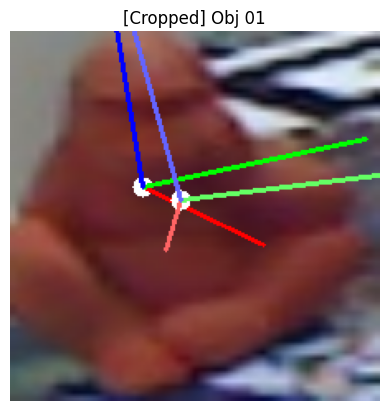

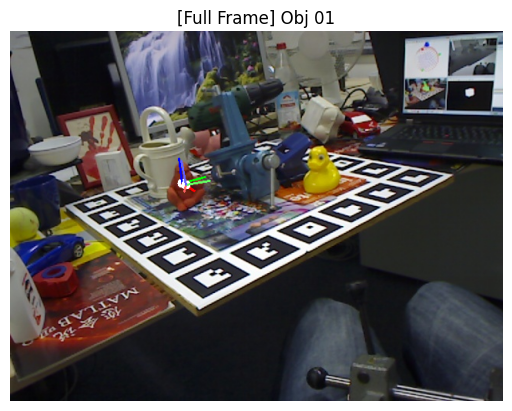


➡️ Mapped object ID 01
ADD: 0.0543 m | Angular Error: 25.94°


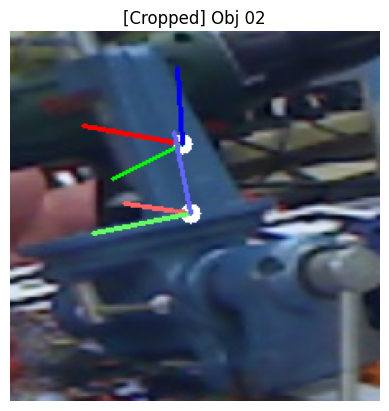

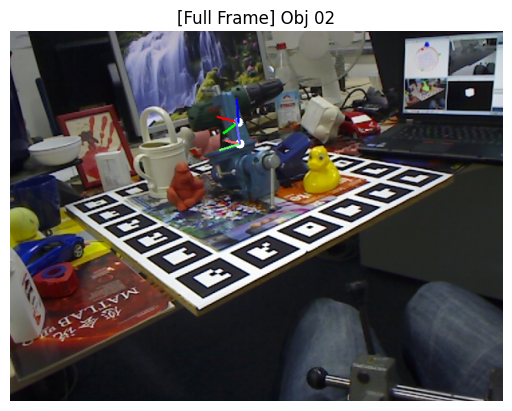


➡️ Mapped object ID 02
ADD: 0.1445 m | Angular Error: 34.75°


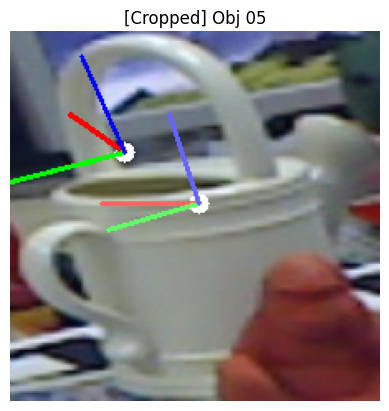

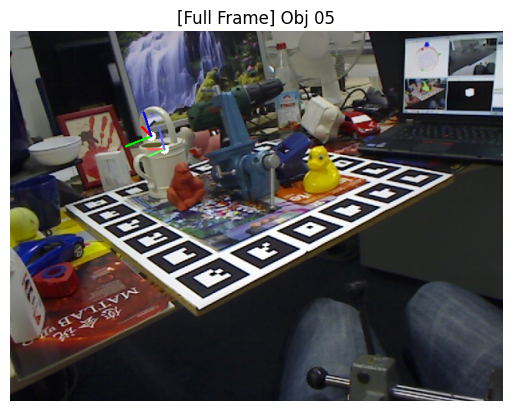


➡️ Mapped object ID 03
ADD: 0.1121 m | Angular Error: 8.20°


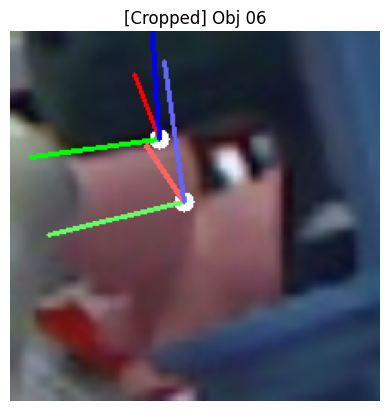

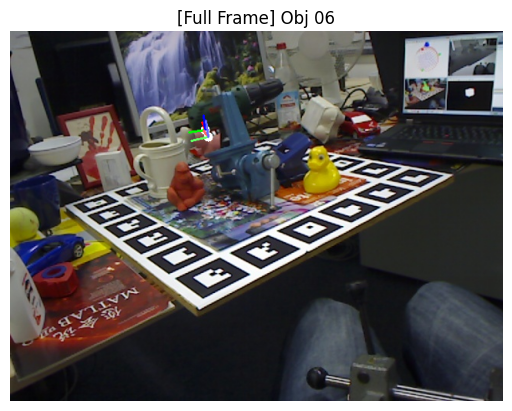


➡️ Mapped object ID 04
ADD: 0.4061 m | Angular Error: 127.21°


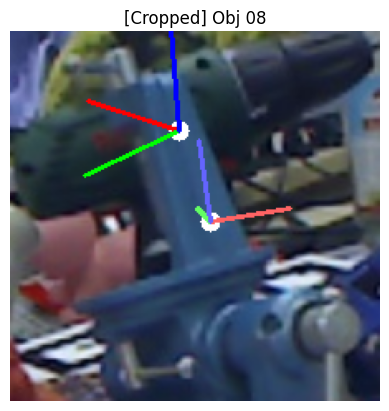

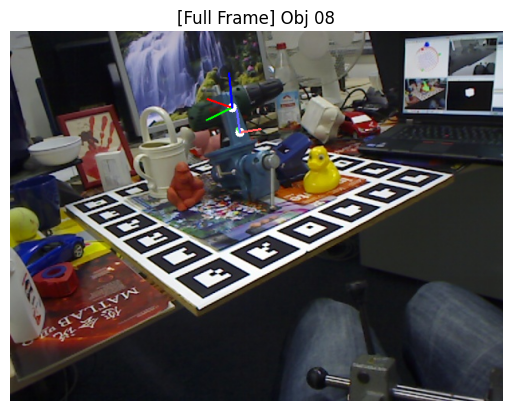


➡️ Mapped object ID 05
ADD: 0.5574 m | Angular Error: 118.55°


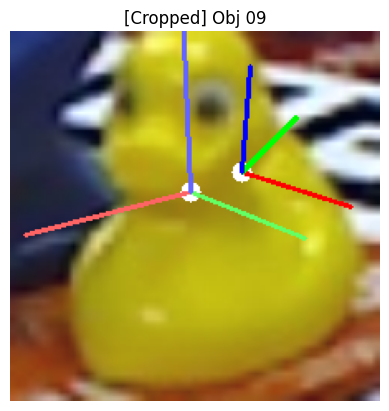

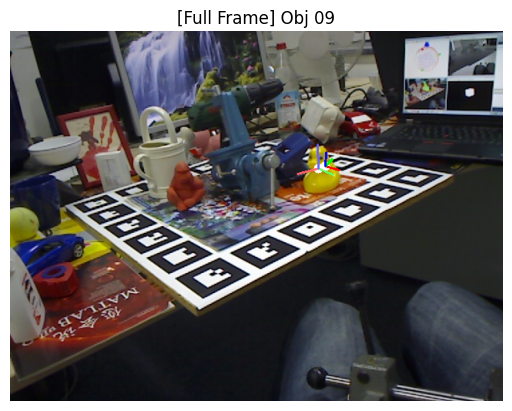


➡️ Mapped object ID 06
ADD: 0.3630 m | Angular Error: 71.50°


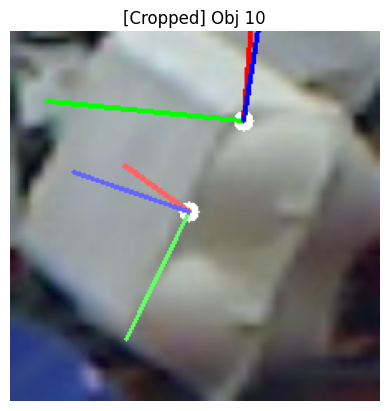

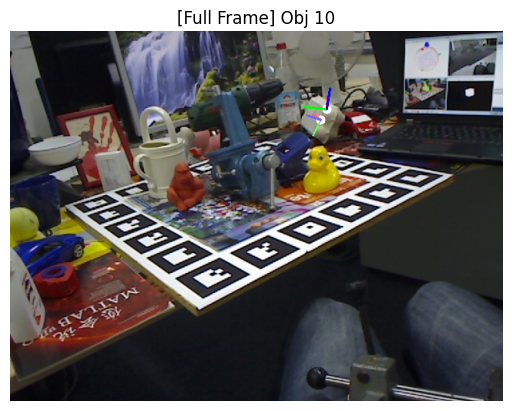


➡️ Mapped object ID 07
ADD: 0.1295 m | Angular Error: 152.73°


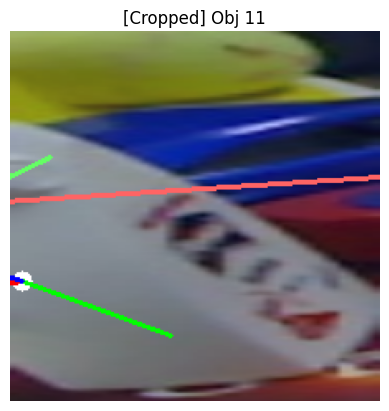

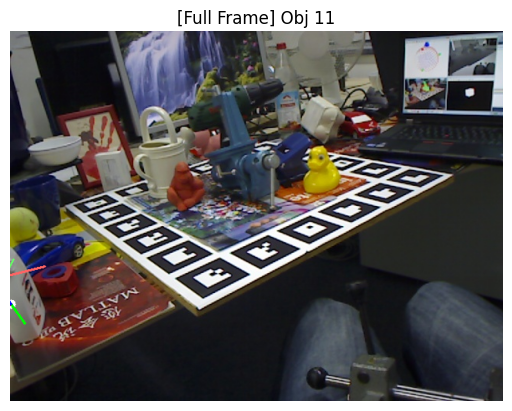


➡️ Mapped object ID 08
ADD: 0.0757 m | Angular Error: 65.80°


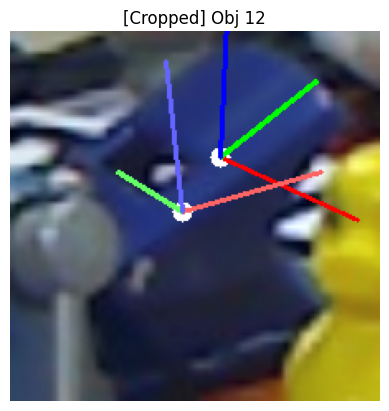

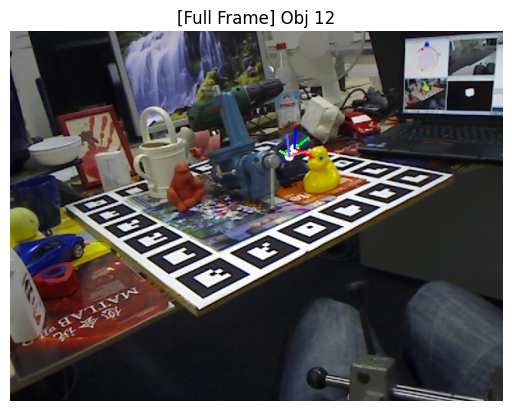

In [ ]:
print("✅ Object IDs in dataset:", dataset.object_ids)  # original IDs
all_mapped_ids, _ = dataset.getMappedIDs()
print("✅ Mapped IDs:", all_mapped_ids)

# What IDs to look out for?
original_ids_to_visualize = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
#original_ids_to_visualize = [13]

# Load model (adjust num_objects to match dataset)
num_objects = len(original_ids_to_visualize)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initializing model.
model = PoseNet_RGBD(num_objects=13) # Has to be the same as the trained model.
model.load_state_dict(torch.load('/content/best_posenet_OP.pt',
                                 map_location=device))
model.to(device)

# --- Set visualization options ---
# Change original_ids_to_visualize to only include objects loaded in the dataset

mapped_ids, _ = dataset.getMappedIDs(original_ids_to_visualize)

img_idx = 20  # Which image index to use
save_dir = "/content/visualizations"

# --- Run visualization ---
run_visualization(
    model=model,
    dataset=dataset,
    device=device,
    target_obj_ids=mapped_ids,
    img_idx=img_idx,
    save_dir=save_dir,
    draw_axes=True,
    draw_legend=False,
    draw_models=False
)